In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Reader():

    def __init__(self, file_name):
        self.file_name = file_name
        self.nparticles = 14
        self.timestep, self.runsteps, self.log_frequency = self.get_metadata()
        self.n_logged_timesteps = int(self.runsteps/self.log_frequency + 1)
        self.logged_timesteps = np.arange(0, self.runsteps+1, self.log_frequency)
    
    def read_original_traj(self, save=True):
        subfix = '-traj.dump'
        lines = []
        with open(self.file_name+subfix, 'r') as f:
            particles_counter = 0
            particles_temp = []
            for i, line in enumerate(f):
                
                if particles_counter == self.nparticles:
                    particles_temp = np.array(particles_temp, dtype=float)
                    particles_temp = particles_temp[particles_temp[:, 0].argsort()]
                    lines.append(particles_temp)
                    particles_counter = 0
                    particles_temp = []
                    continue
                elif particles_counter > 0:
                    line = line.rstrip(' \n')
                    line = line.split()
                    particles_temp.append(line)
                    particles_counter += 1

                else:
                    if i == 8:
                        line = line.lstrip('ITEM: ENTRIES ')
                        labels = line.split()
                    if (i-9) % 23 == 0:
                        line = line.rstrip(' \n')
                        line = line.split()
                        particles_temp.append(line)
                        particles_counter += 1
        
        # TODO: delete atom id and atom type in variable axis
        # [number of timesteps, atom id, variable]
        lines = np.stack(lines)
        
        # HACK: saving as a 3D numpy
        if save:
            np.save(self.file_name+'-original_traj.npy', lines)
        
        return labels, lines

    def read_info_traj(self, save=True):
        subfix = '-info.dat'
        lines = []
        with open(self.file_name+subfix, 'r') as f:
            for i, line in enumerate(f):
                if i == 8:
                    line = line.lstrip('ITEM: ENTRIES ')
                    labels = line.split()
                if (i+1) % 10 == 0:
                    line = line.rstrip(' \n')
                    line = line.split()
                    lines.append(line)
        lines = np.array(lines, dtype=float)

        # TODO: include logged timesteps, once full simulations are run
        if save:
            df = pd.DataFrame(lines, columns=labels)
            df.to_csv(self.file_name+'-info_traj.csv', index=False)
        
        return labels, lines
    
    def read_simulation_log(self):
        subfix = '-sim.log'
        lines = np.zeros([])
        with open(self.file_name+subfix, 'r') as f:
            for i, line in enumerate(f):
                if i < 64:
                    continue
                if i == 64:
                    label = line.split()
                    lines = np.zeros([self.n_logged_timesteps, len(label)])
                    step_no = 0
                else:
                    line = line.rstrip(' \n')
                    line = line.split()
                    try:
                        line = np.array(line, dtype=float)
                    except ValueError:
                        print(f"Breaking - likely reached last line of sim log: {line}")
                        break
                    lines[step_no] = line
                    step_no += 1
        
        return label, lines

    def get_metadata(self):
        subfix = '-input.log'
        with open(self.file_name+subfix, 'r') as f:
            for i, line in enumerate(f):
                if i == 2:
                    log_frequency = int(line.split()[3])
                elif i == 3:
                    runsteps = int(line.split()[3])
                elif i == 4:
                    timestep = float(line.split()[3])

        print(f"Found timestep: {timestep}, n of run steps: {runsteps}, and dump log freq: {log_frequency}")
        return timestep, runsteps, log_frequency

In [10]:
def analyse_simulation(K: float, T: float, SEED: int, R0: float = 0):
    file_name = f'NVE-temp-{T}_K-{K}_r-{R0}_s-{SEED}'

    reader = Reader(file_name)
    log_labels, log_lines = reader.read_simulation_log()
    traj_labels, traj_lines = reader.read_info_traj(save=True)
    orig_labels, orig_lines = reader.read_original_traj(save=True)

    kineticEnergy = log_lines[:, -2]
    forceMagnitude = log_lines[:, 4]

    def moving_average(x, w=1):
        return np.convolve(x, np.ones(w), 'valid') / w

    # x_diff = traj_lines[:, 0] - traj_lines[:, 3]
    # y_diff = traj_lines[:, 1] - traj_lines[:, 4]
    # z_diff = traj_lines[:, 2] - traj_lines[:, 5]
    # com_distance = np.sqrt(x_diff**2 + y_diff**2 + z_diff**2)

    com_distance = np.linalg.norm(traj_lines[:, 0:3] - traj_lines[:, 3:6], axis=1)
    potentialEnergy = - 0.5 * K * (com_distance**2 - R0**2)
    # is this the correct way to calculate all of this? yes, I believe so

    totalEnergy = log_lines[:,-1]
    totalReducedEnergy = totalEnergy - potentialEnergy

    plt.figure(facecolor='white')
    plt.title(f"K = {K} and T = {T} and R0 = {R0}")
    plt.plot(moving_average(totalReducedEnergy), label='total + harmonic potential')
    plt.plot(moving_average(totalEnergy), label='total logged energy')
    # plt.plot(kineticEnergy, label='kinetic (total logged energy)')
    # plt.plot(potentialEnergy, label='calculated harmonic potential')
    # plt.ylim(-1,5)
    # plt.xlim(0,1000)
    plt.xlabel('time steps')
    plt.ylabel('energy')
    plt.legend()
    plt.show()

    # DELTA PLOT

    # deltaPotential = - K / 2 * (com_distance[1:]**2 - com_distance[:-1]**2)
    deltaReduced = totalReducedEnergy[1:] - totalReducedEnergy[:-1]
    deltaEnergy = totalEnergy[1:] - totalEnergy[:-1]

    plt.figure(facecolor='white')
    plt.plot(moving_average(deltaReduced), label='Total Energy (+ harmonic) Change')
    plt.plot(moving_average(deltaEnergy), label='Total Energy Change')
    # plt.xlim(0,1000)
    plt.ylim(-1,1)
    plt.xlabel('Time Steps')
    plt.ylabel('Energy Change')
    plt.legend()
    plt.show()


Found timestep: 1e-05, n of run steps: 50000000, and dump log freq: 10000
Breaking - likely reached last line of sim log: ['Loop', 'time', 'of', '276.659', 'on', '1', 'procs', 'for', '50000000', 'steps', 'with', '14', 'atoms']


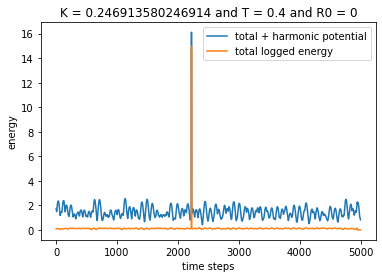

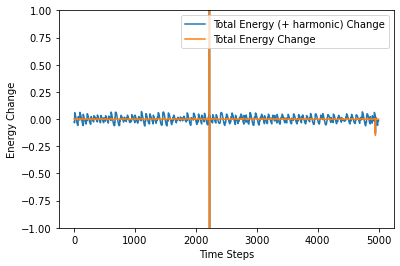

In [11]:
# Temperature 1
analyse_simulation(T=0.4, K=0.246913580246914, SEED=5)
# analyse_simulation(T=1, K=0.01, R0=3, SEED=4)
# # Temperature 0.8
# analyse_simulation(T=0.8, K=0.01, R0=3, SEED=4)
# analyse_simulation(T=0.8, K=0.01, R0=3, SEED=5)
# # Temperature 0.6
# analyse_simulation(T=0.6, K=0.01, R0=3, SEED=4)
# analyse_simulation(T=0.6, K=0.01, R0=3, SEED=5)

# analyse_simulation(T=0.4, K=0.01, R0=3, SEED=5)
# analyse_simulation2(T=0.4, K=0.01, R0=3, SEED=5)


qf = pd.read_csv(file_name+'-info_traj.csv')
# print(qf)
        

In [60]:
info_traj

[-0.00089286  0.0007394   0.00261024  0.00439025  0.00601462  0.00742513
  0.00857145  0.00941268  0.00991885  0.01007193  0.00986645  0.00930974
  0.00842163  0.00723379  0.00578857  0.00413758  0.00234005  0.00046182
 -0.00086034  0.00015874]
[0.00089286 0.0007394  0.00261024 0.00439025 0.00601462 0.00742513
 0.00857145 0.00941268 0.00991885 0.01007193 0.00986645 0.00930974
 0.00842163 0.00723379 0.00578857 0.00413758 0.00234005 0.00046182
 0.00086034 0.00015874]
